In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scipy
from tqdm import tqdm
     

from sparse_recovery.plotters.utils import get_twin_axis, FIGSIZE, LINEWIDTH, FIGSIZE_SMALL, FIGSIZE_LARGE, FIGSIZE_MEDIUM, FONTSIZE, LABEL_FONTSIZE, TICK_LABEL_FONTSIZE, MARKERSIZE
from sparse_recovery.plotters.img_show import custom_imshow

from matplotlib.lines import Line2D
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from sparse_recovery.utils import sample_iterations_for_plotting, select_log_space
from sparse_recovery.utils import plot_t1_t2, find_memorization_generalization_steps, find_stable_step_final_value
from sparse_recovery.compressed_sensing import calculate_coherence
from sparse_recovery.matrix_factorization import get_matrices_UV, get_matrices_IndentityUV, get_matrices_QR_UV, calculate_local_coherence
from sparse_recovery.matrix_factorization import get_data_matrix_factorization, solve_matrix_factorization_nuclear_norm
#from sparse_recovery.matrix_factorization import get_gradient_matrix_factorization, subgradient_descent_matrix_factorization
     

In [4]:
problem = 'matrix-completion'
#problem = 'matrix-sensing'
     

n_1, n_2 = 10, 10  # Dimension of A*
n = n_1 * n_2
symmetric=False
r=5
seed = None
N=3
tau=0.2

#A_star, U_star, Sigma_star, V_star = get_matrices_IndentityUV(n_1, n_2, r, distribution="normal", scaler=None, seed=seed)
A_star, U_star, Sigma_star, V_star = get_matrices_QR_UV(n_1, n_2, r, distribution="normal", scaler=None, seed=seed)
#A_star, U_star, Sigma_star, V_star = get_matrices_UV(n_1, n_2, r, symmetric, normalize=True, scale=None,  seed=seed)

#(10, 9) (10, 10) (9,) (9, 9)
print(A_star.shape, U_star.shape, Sigma_star.shape, V_star.shape)

(X1, X2, _, _), _ = get_data_matrix_factorization(A_star, U_star, V_star, N, problem, tau=tau, variance=1/N, seed=seed)

mu = calculate_coherence(A=X1.T, B=U_star)
nu = calculate_coherence(A=X2.T, B=V_star)
print(mu, nu)

mu, nu, P = calculate_local_coherence(A_star, U_n1=None, V_n2=None)
print(max(mu), max(nu), mu, nu)
     


(10, 10) (10, 10) (10, 10) (10, 10)
1.0 0.7768281085492587
1.6039853166205364 1.5254180415112815 [1.60398532 0.74470723 0.54237161 1.45723987 1.23368719 0.43725171
 0.82763387 0.76890648 1.25655488 1.12766185] [1.52541804 0.86708953 0.43969061 0.71293386 0.84033706 0.81358611
 1.27754162 1.50514572 1.24851987 0.76973759]


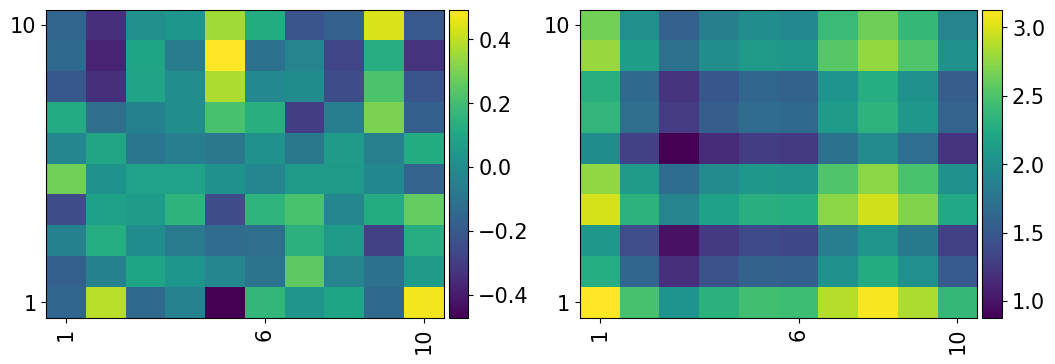

In [9]:
from matplotlib.colors import LogNorm
label_fontsize=20
ticklabel_fontsize=15
rows, cols = 1, 2
figsize=FIGSIZE_SMALL
figsize=(cols*figsize[0], rows*figsize[1])
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(rows, cols, 1)
img_data = A_star # (n_1, n_2)
img = custom_imshow(
    img_data, ax=ax, fig=fig, add_text=False,
    hide_ticks_and_labels=False, xticklabels=np.arange(1, img_data.shape[1]+1), yticklabels=np.arange(1, img_data.shape[0]+1),
    filter_step_xticks=5, filter_step_yticks=10, log_x=False, log_y=False, base=10,
    rotation_x=90, rotation_y=0,
    x_label="",  y_label="",
    # Use LogNorm to apply a logarithmic scale
    colormesh_kwarg={"shading":'auto', "cmap":'viridis'},#, 'norm':LogNorm(vmin=img_data.min(), vmax=img_data.max())},
    imshow_kwarg={},
    colorbar=True, colorbar_label=f'',
    label_fontsize=label_fontsize,
    ticklabel_fontsize=ticklabel_fontsize,
    show=False, fileName=None, dpf=None,
    use_imshow=False
)

ax = fig.add_subplot(rows, cols, 2)
img_data = np.array(P) # (alphas, dimensions)
img = custom_imshow(
    img_data, ax=ax, fig=fig, add_text=False,
    hide_ticks_and_labels=False, xticklabels=np.arange(1, img_data.shape[1]+1), yticklabels=np.arange(1, img_data.shape[0]+1),
    filter_step_xticks=5, filter_step_yticks=10, log_x=False, log_y=False, base=10,
    rotation_x=90, rotation_y=0,
    x_label="",  y_label="",
    # Use LogNorm to apply a logarithmic scale
    colormesh_kwarg={"shading":'auto', "cmap":'viridis'},#, 'norm':LogNorm(vmin=img_data.min(), vmax=img_data.max())},
    imshow_kwarg={},
    colorbar=True, colorbar_label=f'',
    label_fontsize=label_fontsize,
    ticklabel_fontsize=ticklabel_fontsize,
    show=False, fileName=None, dpf=None
)

# # Adjust layout and add padding
fig.tight_layout(pad=2)  # Adjust padding between plots
plt.subplots_adjust(right=0.85)  # Adjust right boundary of the plot to fit color bar

#plt.savefig(f"{LOG_DIR}/coherence_P"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()

In [10]:
A_star, U_star, Sigma_star, V_star = get_matrices_UV(n_1, n_2, r, symmetric, normalize=True, scale=None,  seed=seed)

N_max = n# int(0.9 * n)
all_N = list(range(1, N_max, 1)) # Number of measurements, N < n

all_tau = np.linspace(0, 1, 11)  # Range of tau values to test
all_tau = np.linspace(0, 1, 1*10+1)  # Range of tau values to test
all_tau = np.linspace(0, 1, 2*10+1) # Range of tau values to test

coherences = [ [] for _ in range(len(all_N)) ]
for i, N in tqdm(enumerate(all_N), total=len(all_N)) :
    for j, tau in enumerate(all_tau):
        (X1, X2, _, _), _ = get_data_matrix_factorization(A_star, U_star, V_star, N, problem, tau=tau, variance=1/N, seed=None)

        mu = calculate_coherence(A=X1.T, B=U_star)
        nu = calculate_coherence(A=X2.T, B=V_star)

        coherences[i].append(max(mu, nu))
        #coherences[i].append(np.mean(mu) + np.mean(nu))

100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 67.02it/s]


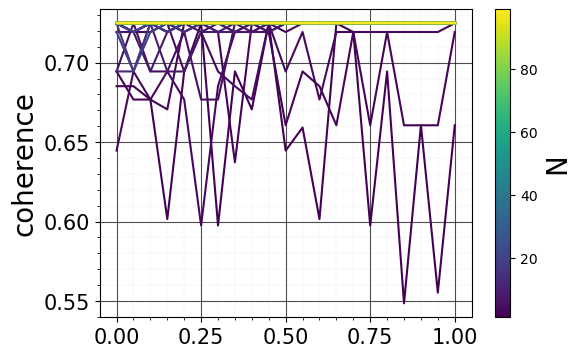

In [11]:
rows, cols = 1, 1
figsize=FIGSIZE
figsize=(cols*figsize[0], rows*figsize[1])
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(rows, cols, 1)
_, ax, _ = get_twin_axis(ax=ax, no_twin=True)
color_indices = np.linspace(0, 1, len(all_N))
colors = plt.cm.viridis(color_indices)
for i, N in enumerate(all_N):
    ax.plot(all_tau, coherences[i], label=f'N={N}', color=colors[i])
ax.set_xlabel('', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('coherence', fontsize=LABEL_FONTSIZE)
ax.tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.grid()
#ax.legend()
# Create a color bar for the sparsity levels `s`
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(all_N), vmax=max(all_N)))
sm.set_array([])  # We only need the colormap here, no actual data
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('N', fontsize=LABEL_FONTSIZE)

#plt.savefig(f"{LOG_DIR}/coherence_tau"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()

In [12]:
problem = 'matrix-completion'
#problem = 'matrix-sensing'

In [13]:
n_1, n_2 = 10, 10  # Dimension of A*
n = n_1 * n_2
symmetric=False
r=2
seed = None
N=10
tau = 1.0

A_star, U_star, Sigma_star, V_star = get_matrices_UV(n_1, n_2, rank=r, symmetric=symmetric, normalize=True, scale=None, seed=seed)

(X1, X2, X2_bullet_X1, y_star), (X1_bar, X2_bar, X2_bullet_X1_bar, y_star_bar) = get_data_matrix_factorization(A_star, U_star, V_star, N, problem, tau=tau, variance=1/N, seed=seed)

A = solve_matrix_factorization_nuclear_norm(
    n_1, n_2, y_star,
    X1X2=(X1, X2), X2_bullet_X1=X2_bullet_X1,
    X1X2_bar=(X1_bar, X2_bar), X2_bullet_X1_bar=X2_bullet_X1_bar, EPSILON=1e-6)

recovery_error = np.linalg.norm(A - A_star, ord="fro") / np.linalg.norm(A_star, ord="fro")
print(recovery_error)

0.7030352882202375


In [ ]:
# Parameters
n_1, n_2 = 10, 10  # Dimension of A*
n = n_1 * n_2
symmetric=False
seed = None

#all_s =  [1, 2]
all_s = [s for s in list(range(1, min(n_1, n_2)+10, 1)) if s <= min(n_1, n_2)] # Rank <= min(n_1, n_2)
#all_s = [s for s in list(range(1, min(n_1, n_2)+10, 5)) if s <= min(n_1, n_2)] # Rank <= min(n_1, n_2)

all_N =  [10, 20, 30]
all_N = list(range(1, n+11, 10)) # Number of measurements N
#all_N = list(range(1, n+11, 1))
if problem == "matrix-completion":
    all_N = [N for N in all_N if N <= n]

all_tau = np.arange(10+1)/10  # Range of tau values to test
# all_tau = [0.0]

errors = {}
min_N_for_s = {}

for iii, tau in enumerate(all_tau):
    print(f"tau = {tau}, {iii+1}/{len(all_tau)}")
    errors[tau] = [ [] for _ in range(len(all_s)) ]
    min_N_for_s[tau] = [None for _ in range(len(all_s))]
    for i, s in tqdm(enumerate(all_s), total=len(all_s)):

        A_star, U_star, Sigma_star, V_star = get_matrices_UV(n_1, n_2, rank=s, symmetric=symmetric, normalize=True, scale=None, seed=None)

        for j, N in enumerate(all_N) :
            error_mean = 0
            n_trials = 2
            for k in range(n_trials):
                # Construct a measurements matrix X and output y
                (X1, X2, X2_bullet_X1, y_star), (X1_bar, X2_bar, X2_bullet_X1_bar, y_star_bar) = get_data_matrix_factorization(A_star, U_star, V_star, N, problem, tau=tau, variance=1/N, seed=None)

                # Solve the l*-minimization problem to recover A
                A = solve_matrix_factorization_nuclear_norm(
                    n_1, n_2, y_star,
                    X1X2=(X1, X2), X2_bullet_X1=X2_bullet_X1,
                    X1X2_bar=(X1_bar, X2_bar), X2_bullet_X1_bar=X2_bullet_X1_bar, EPSILON=1e-6)

                recovery_error = np.linalg.norm(A - A_star, ord="fro") / np.linalg.norm(A_star, ord="fro")
                error_mean += recovery_error

            error_mean /= n_trials
            errors[tau][i].append(error_mean)
            if error_mean < 1e-3 and min_N_for_s[tau][i] is None:
                min_N_for_s[tau][i] = N

tau = 0.0, 1/11


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


tau = 0.1, 2/11


 20%|████████▊                                   | 2/10 [00:01<00:06,  1.27it/s]